In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [5]:
# Data from N-2 rocket
# Tana is the first rocket launched
# It went up to around 80m
df = pd.read_csv('tanafull.csv')

In [6]:
df

,altitude,filtered_a,filtered_s,filtered_v,gx,gy,gz,latitude,longitude,state,temperature
0,1272.909,0.014,1273.154,0.064,-0.001,0.018,0.017,0,0,0,44.983
1,1272.909,0.014,1273.154,0.064,-0.001,0.018,0.017,0,0,0,44.983
2,1272.901,0.012,1273.140,0.057,-0.010,0.019,0.017,0,0,0,44.983
3,1272.901,0.012,1273.140,0.057,-0.010,0.019,0.017,0,0,0,44.983
4,1272.820,0.010,1273.120,0.047,0.001,0.019,0.017,0,0,0,44.974
...,...,...,...,...,...,...,...,...,...,...,...
1826,1284.050,-5.711,1283.788,-27.098,-8.731,-0.286,0.436,0,0,3,45.836
1827,1284.050,-5.711,1283.788,-27.098,-8.731,-0.286,0.436,0,0,3,45.836
1828,1283.649,-5.698,1281.238,-27.597,-8.731,-0.435,1.262,0,0,4,45.774
1829,1283.649,-5.698,1281.238,-27.597,-8.731,-0.435,1.262,0,0,4,45.774


In [8]:
# Trim the data frame
# Kalman filtered Altitude
df2 = df['filtered_s'][1600:]

<AxesSubplot:>

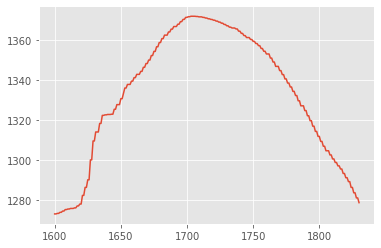

In [14]:
# See the data looks like
df2.plot()

In [48]:
# Apogee detection algorithm 1
# If there is 5 times consecutive decrease in altitude, it is recognized as the apogee.
def detect(xs,MAX_COUNT):
    last = xs[0]
    # MAX_COUNT = 1
    indicator = MAX_COUNT
    print(indicator,end=',')
    for i,cur in enumerate(xs[1:]):
        if (cur > last):
            if (indicator < MAX_COUNT):
                indicator = MAX_COUNT
                print(indicator,end=',')
        if (cur < last):
            indicator -= 1
            print(indicator,end=',')
            if indicator == 0:
                print()
                print("Apogee detected at {0} frame. Apogee: {1} [m]".format(i+1,cur))
                return(i+1,cur)
        last = cur

In [88]:
# Test the logic
alt = np.array(df2)
true_apogee_index = np.argmax(alt)
true_apogee = max(alt)
counters=[]
delay_frames=[]
delays=[]
for i in [5,4,3,2,1]:
    [frame,apogee] = detect(alt, i)
    delay = (frame-true_apogee_index)*sampling_period
    delay_frame = frame-true_apogee_index
    print("Delay frames: {0}:".format(delay_frame))
    print("Delay second: {0:.2f}[sec]".format(delay))
    delay_frames.append(delay_frame)
    delays.append(delay)
dic = {"count": [5,4,3,2,1], "delays [sec]": delays, "delay_frames": delay_frames}
delay_df = pd.DataFrame(data=dic)
delay_df

5,4,3,2,1,0,
Apogee detected at 114 frame. Apogee: 1371.066 [m]
Delay frames: 11:
Delay second: 0.81[sec]
4,3,2,1,0,
Apogee detected at 112 frame. Apogee: 1371.385 [m]
Delay frames: 9:
Delay second: 0.67[sec]
3,2,1,0,
Apogee detected at 109 frame. Apogee: 1371.659 [m]
Delay frames: 6:
Delay second: 0.44[sec]
2,1,0,
Apogee detected at 107 frame. Apogee: 1371.847 [m]
Delay frames: 4:
Delay second: 0.30[sec]
1,0,
Apogee detected at 105 frame. Apogee: 1371.948 [m]
Delay frames: 2:
Delay second: 0.15[sec]


,count,delays [sec],delay_frames
0,5,0.814,11
1,4,0.666,9
2,3,0.444,6
3,2,0.296,4
4,1,0.148,2


5,4,3,2,1,0,
Apogee detected at 114 frame. Apogee: 1371.066 [m]



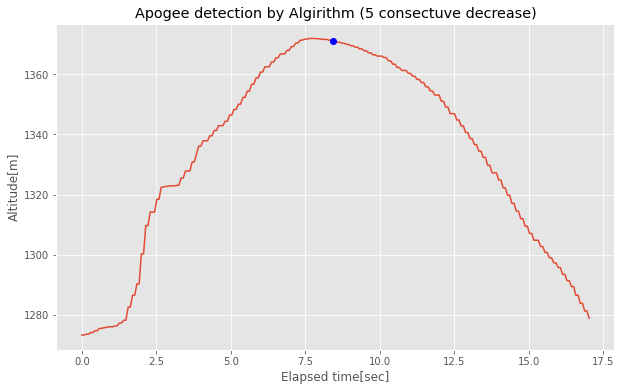

In [103]:
fig, ax = plt.subplots(1, 1,figsize=(10,6))
alt = np.array(df2)
n_sample = len(alt)
# sampling_period = 0.2
sampling_period = 0.074
# 74ms
t = np.arange(0,n_sample*sampling_period,sampling_period)
ax.plot(t,alt)


COUNT = 5
[frame,apogee] = detect(alt, COUNT)
x = sampling_period*frame
y = df2.iloc[frame]
ax.plot(x,y,'bo')

plt.xlabel('Elapsed time[sec]')
plt.ylabel('Altitude[m]')
plt.title("Apogee detection by Algirithm ({0} consectuve decrease)".format(MAX_COUNT))
print()